# Predict bad LS moves

This notebook develops simple models for predicting bad local search moves. Particularly, given routes $R_U$ and $R_V$, it predicts whether the route-based LS operators we currently have are likely to produce an improving solution if the operator were to be applied to these route pairs.

In [1]:
%cd ..

D:\Projects\Python\Euro-NeurIPS-2022


In [2]:
%matplotlib inline

In [3]:
from collections import defaultdict
from contextlib import suppress
from dataclasses import dataclass
from enum import IntEnum
from glob import glob
from functools import cache
import itertools
from pathlib import Path
import re
from typing import Optional

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import KFold
from sklearn.utils import resample

import tools

In [4]:
DATA_PATH = Path("data/raw/")
INST_PATH = Path("instances/")

## Utilities

These are used to parse the raw results for a single instance into something that contains the same data, but in a more workable format.

In [5]:
@dataclass
class Route:
    clients: list[int]
    load: int
    tw: int

    def index(self, client: int) -> int:
        return self.clients.index(client)

    def __getitem__(self, idx: int) -> int:
        return self.clients[idx]

    def __len__(self) -> int:
        return len(self.clients)


@dataclass
class Record:
    op: int
    delta: int
    Ru: tuple[Route, Optional[Route]]  # tuples of (before, after). After only
    Rv: tuple[Route, Optional[Route]]  # when delta is negative.


def parse_file(file: str) -> list[Record]:
    def parse_record(record: list[str]) -> Record:
        op, delta = map(int, record[0].split(" "))
        _, *Ru = map(int, re.findall('[0-9]+', record[1].strip()))
        _, *Rv = map(int, re.findall('[0-9]+', record[2].strip()))
        Lu, Lv = map(int, record[3].split(" "))
        TWu, TWv = map(int, record[4].split(" "))

        uRouteBefore = Route(Ru, Lu, TWu)  # before
        vRouteBefore = Route(Rv, Lv, TWv)  # before
        
        uRouteAfter = None
        vRouteAfter = None
        
        if delta < 0:
            _, *Ru = map(int, re.findall('[0-9]+', record[5].strip()))
            _, *Rv = map(int, re.findall('[0-9]+', record[6].strip()))
            Lu, Lv = map(int, record[7].split(" "))
            TWu, TWv = map(int, record[8].split(" "))
            
            uRouteAfter = Route(Ru, Lu, TWu)
            vRouteAfter = Route(Rv, Lv, TWv)

        return Record(op, 
                      delta, 
                      (uRouteBefore, uRouteAfter), 
                      (vRouteBefore, vRouteAfter))

    with open(file, 'r') as fh:
        records = []
        lines = fh.readlines()
        idx = 0

        while idx != len(lines):
            try:
                op, delta = map(int, lines[idx].split(" "))

                if delta < 0:
                    record = lines[idx : idx + 9]
                    records.append(parse_record(record))
                    idx += 9
                else:
                    record = lines[idx : idx + 5]
                    records.append(parse_record(record))
                    idx += 5
            except:
                print(f"{file}: exception at {idx} of {len(lines)}; returning")
                return records

        return records

## Data and feature generation

Operators (in the order of `main.cpp`):

0. RELOCATE*
1. SWAP*

In [6]:
class Features(IntEnum):
    TW_U_INFEAS = 0
    TW_V_INFEAS = 1
    LD_U_INFEAS = 2
    LD_V_INFEAS = 3
    U_SIZE = 4
    V_SIZE = 5
    UV_ANGLE_DIFF = 6
    MAX_UDEPOT_DIST = 7
    MAX_VDEPOT_DIST = 8
    MAX_UV_ANGLE = 9

In [7]:
def angle(dx, dy):
    if dy < 0:
        return -abs(1 - dx / (abs(dx) + abs(dy)))

    return abs(1 - dx / (abs(dx) + abs(dy)))


def pseudo_angle(coords, idcs):
    if len(idcs) == 0:
        return 0

    dx = coords[idcs][:, 0].mean() - coords[0, 0]
    dy = coords[idcs][:, 1].mean() - coords[0, 1]

    return angle(dx, dy)

In [8]:
def make_features(instance: dict, records: list[Record]) -> np.array:
    data = np.zeros((len(records), len(Features)))
    coords = instance['coords']
    dist = instance['duration_matrix']
    max_dist = dist.max()

    for idx, record in enumerate(records):
        uRouteBefore, uRouteAfter = record.Ru
        vRouteBefore, vRouteAfter = record.Rv

        data[idx, Features.TW_U_INFEAS] = uRouteBefore.tw > 0
        data[idx, Features.TW_V_INFEAS] = vRouteBefore.tw > 0

        data[idx, Features.LD_U_INFEAS] = uRouteBefore.load > instance['capacity']
        data[idx, Features.LD_V_INFEAS] = vRouteBefore.load > instance['capacity']

        data[idx, Features.U_SIZE] = len(uRouteBefore) / len(coords)
        data[idx, Features.V_SIZE] = len(vRouteBefore) / len(coords)

        uAngle = pseudo_angle(coords, uRouteBefore.clients)
        vAngle = pseudo_angle(coords, vRouteBefore.clients)

        assert -2 <= uAngle <= 2, f"Got: {uAngle} for {uRouteBefore}"
        assert -2 <= vAngle <= 2, f"Got: {vAngle} for {vRouteBefore}"

        data[idx, Features.UV_ANGLE_DIFF] = vAngle - uAngle  # in [-4, 4]

        angle_u = 0
        angle_v = 0
        
        if len(uRouteBefore):
            idx_mx_u = max(range(len(uRouteBefore)), 
                           key=lambda idx: dist[0, uRouteBefore[idx]])

            angle_u = pseudo_angle(coords, [uRouteBefore[idx_mx_u]])
            data[idx, Features.MAX_UDEPOT_DIST] = dist[0, uRouteBefore[idx_mx_u]] / max_dist

        if len(vRouteBefore):
            idx_mx_v = max(range(len(vRouteBefore)), 
                           key=lambda idx: dist[0, vRouteBefore[idx]])

            angle_v = pseudo_angle(coords, [vRouteBefore[idx_mx_v]])
            data[idx, Features.MAX_VDEPOT_DIST] = dist[0, vRouteBefore[idx_mx_v]] / max_dist

        # Angle between clients with maximum distance to depot (in U and V)
        data[idx, Features.MAX_UV_ANGLE] = angle_v - angle_u  # in [-4, 4]
        
    return data

In [24]:
def make_or_retrieve_data(file_loc: str) -> tuple[np.array, np.array]:
    cache_loc = DATA_PATH / (Path(file_loc).stem + '.npz')

    if cache_loc.exists():
        file = np.load(cache_loc)
        return file['X'], file['y']                

    instance = tools.read_vrplib(INST_PATH / file_loc)
    records = parse_file(DATA_PATH / file_loc)

    y = np.array([int(record.delta < 0) for record in records])
    X = make_features(instance, records)

    np.savez(cache_loc, X=X, y=y)
    return X, y

## Training and evaluation

In [10]:
files = sorted([Path(file.name) for file in DATA_PATH.glob("ORTEC-*.txt")])

In [11]:
avg = [make_or_retrieve_data(file)[1].mean() for file in files]
np.mean(avg)

data\raw\ORTEC-VRPTW-ASYM-b345b203-d1-n215-k15.txt: exception at 674890 of 709991; returning


0.002314431465259039

[[ 0.94795131  0.94009727  3.26525786  1.40285488  2.52814362 -9.29188939
   1.07194612  0.5748352   3.80550205  0.9215295 ]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.66    170515
           1       0.00      0.69      0.00       185

    accuracy                           0.50    170700
   macro avg       0.50      0.59      0.33    170700
weighted avg       1.00      0.50      0.66    170700



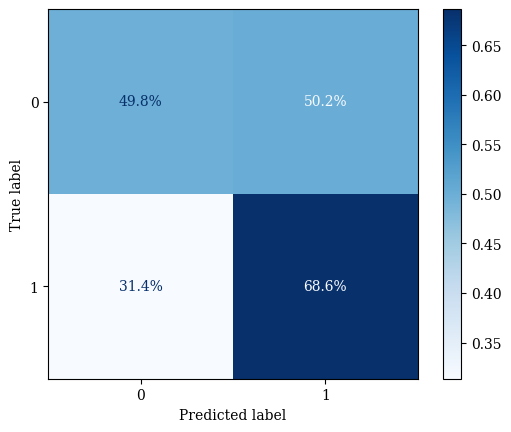

In [12]:
model = SGDClassifier(loss="log_loss", random_state=1)

X, y = make_or_retrieve_data(files[0])
X_maj, X_min = X[y == 0, :], X[y == 1, :]

# Downsample dominant class
X_maj = resample(X_maj, replace=False, n_samples=y.sum(), random_state=123)

X_train = np.vstack([X_min, X_maj])
y_train = np.hstack([np.ones(y.sum()), np.zeros(y.sum())])

model.fit(X_train, y_train)

X_test, y_test = make_or_retrieve_data(files[1])
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        normalize='true', 
                                        cmap='Blues',
                                        values_format='.1%')

In [30]:
def do_kfold(n_splits: int, n_iters: int, files: list[Path]) -> list:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    fold_results = []

    for fold_idx, (train, test) in enumerate(kf.split(files), 1):
        print(f"Fold {fold_idx}")
        rnd_state = rnd.RandomState(fold_idx)
        model = SGDClassifier(loss="log_loss", random_state=rnd_state)

        for _ in range(n_iters):
            rnd_state.shuffle(train)

            for idx in train:
                X, y = make_or_retrieve_data(files[idx])

                # Downsample dominant class to combat bias a bit (since
                # improving moves are << 1% of total moves)
                X_maj, X_min = X[y == 0, :], X[y == 1, :]
                X_maj = resample(X_maj, 
                                 replace=False,
                                 n_samples=y.sum(),
                                 random_state=rnd_state)

                X_train = np.vstack([X_min, X_maj])
                y_train = np.hstack([np.ones(y.sum()), np.zeros(y.sum())])

                model.partial_fit(X_train, y_train, [0, 1])

        scores = []
        for idx in test:
            X_test, y_test = make_or_retrieve_data(files[idx])
            precision, recall, f1score, _ = score(y_test,
                                                  model.predict(X_test),
                                                  average='weighted',
                                                  zero_division='warn')

            # Precision: number of relevant documents retrieved by a search 
            #            divided by the total number of documents retrieved
            # Recall: number of relevant documents retrieved by a search 
            #         divided by the total number of existing relevant documents
            # F1 score: 2 * (precision * recall) / (precision + recall)
            scores.append([precision, recall, f1score])

        mean_scores = np.mean(scores, axis=0)
        fold_results.append([mean_scores, model.coef_[0], model.intercept_])

    return fold_results

In [31]:
vals = do_kfold(n_splits=5, n_iters=50, files=files)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


Folding results: precision, recall, and F1 score. The best folding result (according to F1 score) is marked with a \*, but the coefficients and performance should all be roughly similar across folds.

In [32]:
idx_max = max(range(len(vals)), key=lambda idx: vals[idx][0][2])

for idx, ((p, r, f1), coefs, intercept) in enumerate(vals, 1):
    print(f"   FOLD: {idx}")
    print(f"   PREC: {p:.3f}")
    print(f" RECALL: {r:.3f}")
    print("*" if idx - 1 == idx_max else " ", f"   F1: {f1:.3f}")

    coefs = [intercept[0]] + coefs.tolist()
    fmt = "{:6.2f} " * len(coefs)
    print(f" COEFFS: {fmt.format(*coefs)}", end="\n\n")

   FOLD: 1
   PREC: 0.996
 RECALL: 0.594
     F1: 0.720
 COEFFS:  -0.37   0.49   0.36   0.79   0.68   0.67  -1.87   0.20  -0.28   1.08   0.14 

   FOLD: 2
   PREC: 0.996
 RECALL: 0.777
*    F1: 0.867
 COEFFS:  -0.45   0.50   0.37   0.78   0.66   0.59  -1.74   0.24  -0.30   1.04   0.06 

   FOLD: 3
   PREC: 0.996
 RECALL: 0.435
     F1: 0.570
 COEFFS:  -0.26   0.51   0.41   0.80   0.66   0.40  -1.91   0.18  -0.32   1.02  -0.05 

   FOLD: 4
   PREC: 0.996
 RECALL: 0.612
     F1: 0.737
 COEFFS:  -0.35   0.47   0.34   0.72   0.61   0.57  -1.96   0.32  -0.32   1.11   0.05 

   FOLD: 5
   PREC: 0.996
 RECALL: 0.444
     F1: 0.559
 COEFFS:  -0.32   0.46   0.35   0.75   0.60   0.58  -1.95   0.26  -0.21   1.12  -0.01 

